# practica_01_jordi_blasco_lozano  
February 16, 2026

## 1 Práctica 1 — Maximum Clique (Clique Problem)

**Autor:** Jordi Blasco Lozano

### 1.0.1 Índice

1. Resumen e introducción  
2. Implementación (funciones y clases auxiliares)  
3. Ejercicio 1 — Baseline exacto: Brute Force  
4. Ejercicio 2 — Relajación continua: Motzkin–Straus  
5. Ejercicio 3 — Replicator Dynamics (RD) + Decoder  
6. Comparativa final (tablas + visualizaciones)  
7. Discusión y conclusiones


## 1.1 Resumen

Este notebook resuelve la Práctica 1 (Maximum Clique) siguiendo un pipeline incremental:

1. **Brute force** para obtener *ground truth* en grafos pequeños (baseline exacto).  
2. **Motzkin–Straus** para entender cómo el problema discreto se relaja a una optimización continua sobre el simplex.  
3. **Replicator Dynamics (RD)** (formulación de Pelillo) para resolver la relajación continua de forma iterativa, y un **decoder greedy** para recuperar una clique discreta.  
4. Experimentos en **IMDB-BINARY** y **COLLAB** (TU Dortmund vía PyG): tamaño medio de clique, tiempo de cómputo y, cuando es posible, comparación contra brute force.

La idea clave es que, aunque Maximum Clique es NP-hard, la relajación continua + RD suele encontrar cliques grandes de manera eficiente, especialmente cuando el grafo tiene estructura densa local.

## 1.2 1. Introducción

Una **clique** en un grafo no dirigido es un conjunto de nodos tal que **toda pareja** de nodos está conectada por una arista. La **maximum clique** es la de mayor tamaño.

Brute force es la forma más directa de resolverlo (enumerar subconjuntos), pero explota en tiempo exponencial. La parte interesante de esta práctica es que, gracias al teorema de **Motzkin–Straus**, podemos transformar el problema en uno continuo: maximizar una forma cuadrática en el **simplex**. A partir de ahí, **Replicator Dynamics** proporciona un algoritmo multiplicativo que respeta las restricciones del simplex y mejora la función objetivo de manera monótona.

A lo largo del notebook mantengo el mismo criterio que en la Práctica 00: agrupar en una sección de “Implementación” todas las funciones auxiliares para dejar los ejercicios limpios y centrados en el análisis.


## 1.3 2. Implementación: funciones y clases auxiliares

En este bloque agrupo los imports, funciones de ayuda (conversión a matriz de adyacencia, chequeo de cliques, evaluadores) y un pequeño “runner” para mantener el notebook limpio.  
La idea es la misma que en la Práctica 00: en los ejercicios únicamente llamo a estas funciones, evitando repetir código y facilitando la lectura de la entrega.


In [1]:
# Imports necesarios
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from itertools import combinations
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

import os
from IPython.display import display

# Crear carpeta de salida para figuras (evita errores al guardar plots)
os.makedirs('images', exist_ok=True)

# (Opcional) PyTorch / PyG: solo necesario para cargar datasets TU Dortmund con PyG
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx

# Configuración de reproducibilidad
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Definir dispositivo (por consistencia con la Práctica 00; aquí lo usamos solo si ampliamos)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print(f"NumPy version: {np.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Using device: {device}")
print("Setup completado")


NumPy version: 1.26.4
PyTorch version: 2.0.1
CUDA available: False
Using device: cpu
Setup completado


In [2]:
def pyg_to_adjacency(data, make_undirected=True, dtype=float):
    """
    Convierte un PyG Data (grafo) a matriz de adyacencia numpy.

    Args:
        data: PyG Data
        make_undirected: si True, fuerza grafo no dirigido
        dtype: dtype de la matriz devuelta

    Returns:
        A: np.ndarray (n, n) con entradas 0/1 (diagonal 0)
        G: networkx.Graph equivalente
    """
    G = to_networkx(data, to_undirected=make_undirected)
    # Asegurar que los nodos estén etiquetados 0..n-1 (PyG suele cumplirlo)
    A = nx.to_numpy_array(G, dtype=dtype)
    # Por claridad, anulamos diagonal (no usamos self-loops en esta práctica)
    np.fill_diagonal(A, 0.0)
    return A, G


def is_clique(nodes, A):
    """
    Check if a set of nodes forms a clique.

    Args:
        nodes: list of node indices
        A: numpy array of shape (n, n) - adjacency matrix

    Returns:
        bool: True if nodes form a clique, False otherwise
    """
    nodes = list(nodes)
    if len(nodes) <= 1:
        return True

    # Verificar que toda pareja esté conectada
    for i, j in combinations(nodes, 2):
        if A[i, j] == 0:
            return False
    return True


def brute_force_max_clique(A):
    """
    Find the maximum clique by brute force enumeration.

    Args:
        A: numpy array of shape (n, n) - adjacency matrix

    Returns:
        list: nodes forming the maximum clique
    """
    n = A.shape[0]
    # Recorremos tamaños de clique de mayor a menor; primera válida => máxima
    for k in range(n, 0, -1):
        for subset in combinations(range(n), k):
            if is_clique(subset, A):
                return list(subset)
    return []


def motzkin_straus_objective(x, A):
    """
    Compute the Motzkin-Straus objective f(x) = x^T A x

    Args:
        x: numpy array of shape (n,) - point in the simplex
        A: numpy array of shape (n, n) - adjacency matrix

    Returns:
        float: objective value
    """
    x = np.asarray(x, dtype=float).reshape(-1)
    return float(x @ A @ x)


def regularized_objective(x, A):
    """
    Compute the regularized objective f_hat(x) = x^T (A + 0.5*I) x

    Args:
        x: numpy array of shape (n,) - point in the simplex
        A: numpy array of shape (n, n) - adjacency matrix

    Returns:
        float: regularized objective value
    """
    x = np.asarray(x, dtype=float).reshape(-1)
    n = A.shape[0]
    A_reg = A + 0.5 * np.eye(n, dtype=float)
    return float(x @ A_reg @ x)


def replicator_dynamics(A, max_iter=1000, tol=1e-12, use_regularization=True):
    """
    Run Replicator Dynamics to find the maximum clique.

    This follows the formulation from Pelillo et al.:
        x_new = x * (A @ x)
        x_new = x_new / x_new.sum()

    Args:
        A: numpy array of shape (n, n) - adjacency matrix
        max_iter: int - maximum number of iterations
        tol: float - convergence tolerance (L1 change)
        use_regularization: bool - whether to use A + 0.5*I

    Returns:
        x: numpy array of shape (n,) - final simplex point
        history: dict with 'objectives' and 'iterations'
    """
    A = np.asarray(A, dtype=float)
    n = A.shape[0]

    # Regularización para evitar soluciones espurias (caso 'cherry', etc.)
    if use_regularization:
        A_reg = A + 0.5 * np.eye(n, dtype=float)
    else:
        A_reg = A.copy()

    # Barycenter
    x = np.ones(n, dtype=float) / n

    objectives = [float(x @ A_reg @ x)]
    it = 0

    for t in range(max_iter):
        it = t + 1
        x_old = x.copy()

        Ax = A_reg @ x
        x = x * Ax  # Hadamard

        s = x.sum()
        if s <= 0:
            # Grafo degenerado (sin aristas) => volvemos al barycenter y paramos
            x = np.ones(n, dtype=float) / n
            break
        x = x / s

        objectives.append(float(x @ A_reg @ x))

        # Convergencia: cambio L1
        if np.sum(np.abs(x - x_old)) < tol:
            break

    history = {'objectives': objectives, 'iterations': it}
    return x, history


def decode_clique(x, A, threshold=1e-6):
    """
    Extract the maximum clique from the RD solution.

    Strategy:
    1. Sort nodes by x value (descending)
    2. Greedily add nodes that maintain clique property

    Args:
        x: numpy array of shape (n,) - RD solution
        A: numpy array of shape (n, n) - adjacency matrix
        threshold: float - minimum x value to consider

    Returns:
        clique: list of node indices
    """
    x = np.asarray(x, dtype=float).reshape(-1)
    n = x.shape[0]
    A = np.asarray(A, dtype=float)

    order = np.argsort(-x)  # descending
    clique = []

    for i in order:
        if x[i] < threshold and len(clique) > 0:
            break

        # Can_Extend(C, i, A)
        ok = True
        for j in clique:
            if A[j, i] == 0:
                ok = False
                break

        if ok:
            clique.append(int(i))

    # Pequeño “polish”: intentar extender con el resto (por si threshold corta demasiado pronto)
    # Esto mantiene la propiedad de clique por construcción.
    for i in order:
        if int(i) in clique:
            continue
        ok = True
        for j in clique:
            if A[j, i] == 0:
                ok = False
                break
        if ok:
            clique.append(int(i))

    return clique


def visualize_rd(A, graph_name="Test Graph", use_regularization=True):
    """
    Run RD and create visualization of convergence.
    """
    x_final, history = replicator_dynamics(A, max_iter=2000, tol=1e-12, use_regularization=use_regularization)
    clique = decode_clique(x_final, A)
    n = A.shape[0]

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    # Plot 1: Objective value over time (monótono en teoría)
    axes[0].plot(history['objectives'], alpha=0.9)
    axes[0].set_title('Objetivo (xᵀ(A+0.5I)x)')
    axes[0].set_xlabel('Iteración')
    axes[0].set_ylabel('Valor')

    # Plot 2: Distribución final de x
    axes[1].bar(np.arange(n), x_final, alpha=0.9)
    axes[1].set_title('x final (barycenter → soporte)')
    axes[1].set_xlabel('Nodo')
    axes[1].set_ylabel('xᵢ')

    # Plot 3: Grafo coloreado por x (y borde rojo si está en la clique decodificada)
    G = nx.from_numpy_array(np.asarray(A, dtype=float))
    pos = nx.spring_layout(G, seed=42)

    node_vals = x_final
    nodes = list(G.nodes())

    nx.draw_networkx_edges(G, pos, ax=axes[2], alpha=0.35, width=0.8)
    sc = nx.draw_networkx_nodes(
        G, pos, ax=axes[2],
        node_color=[node_vals[i] for i in nodes],
        node_size=250,
        cmap='viridis'
    )
    # Resaltar clique
    nx.draw_networkx_nodes(
        G, pos, ax=axes[2],
        nodelist=clique,
        node_size=330,
        node_color='none',
        edgecolors='crimson',
        linewidths=2.0
    )
    axes[2].set_title(f'Grafo coloreado por x (clique size={len(clique)})')
    axes[2].axis('off')
    plt.colorbar(sc, ax=axes[2], fraction=0.046, pad=0.04)

    plt.suptitle(f"Replicator Dynamics — {graph_name}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return x_final, history, clique


class CliqueExperiment:
    """
    Clase ligera para evaluar brute force y RD en datasets (y comparar contra ground truth cuando sea posible).

    Igual que en la Práctica 00, la idea es: ejecutar -> almacenar resultados en DataFrames
    -> visualizar y resumir sin imprimir demasiado.
    """

    def __init__(self):
        self._bf_rows = []
        self._rd_rows = []

    def run_bruteforce(self, dataset, dataset_name, max_graphs=20, max_nodes=25):
        self._bf_rows = []
        for i in tqdm(range(min(max_graphs, len(dataset))), desc=f'Brute force — {dataset_name}'):
            data = dataset[i]
            n = int(data.num_nodes)
            if n > max_nodes:
                # Saltamos por coste exponencial
                continue

            A, _ = pyg_to_adjacency(data, make_undirected=True)
            start = time.time()
            clique = brute_force_max_clique(A)
            elapsed = time.time() - start

            self._bf_rows.append({
                'Dataset': dataset_name,
                'graph_idx': i,
                'num_nodes': n,
                'clique_size': len(clique),
                'clique': clique,
                'time': elapsed
            })

        return pd.DataFrame(self._bf_rows)

    def run_rd(self, dataset, dataset_name, num_graphs=50, max_iter=1000, tol=1e-12, use_regularization=True):
        self._rd_rows = []
        for i in tqdm(range(min(num_graphs, len(dataset))), desc=f'RD — {dataset_name}'):
            data = dataset[i]
            A, _ = pyg_to_adjacency(data, make_undirected=True)

            start = time.time()
            x_final, hist = replicator_dynamics(A, max_iter=max_iter, tol=tol, use_regularization=use_regularization)
            clique = decode_clique(x_final, A)
            elapsed = time.time() - start

            valid = is_clique(clique, A)

            self._rd_rows.append({
                'Dataset': dataset_name,
                'graph_idx': i,
                'num_nodes': int(data.num_nodes),
                'clique_size': len(clique),
                'clique': clique,
                'valid': bool(valid),
                'time': elapsed,
                'iterations': int(hist['iterations'])
            })

        return pd.DataFrame(self._rd_rows)

    @staticmethod
    def summarize(df, title=None):
        if df.empty:
            return pd.DataFrame()

        summary = df.agg({
            'clique_size': ['mean', 'std', 'min', 'max'],
            'time': ['mean', 'std', 'min', 'max'],
        }).T
        summary.columns = ['Mean', 'Std', 'Min', 'Max']
        summary = summary.reset_index().rename(columns={'index': 'Metric'})
        if title:
            print(title)
        return summary

    @staticmethod
    def compare_against_ground_truth(df_bf, df_rd):
        """
        Compara RD vs brute force en los grafos que tengan ground truth (merge por graph_idx).
        Devuelve un DataFrame con métricas y un resumen agregado.
        """
        if df_bf.empty or df_rd.empty:
            return pd.DataFrame(), pd.DataFrame()

        merged = df_rd.merge(df_bf[['graph_idx', 'clique_size']], on='graph_idx', how='inner', suffixes=('_rd', '_bf'))
        merged['exact_match'] = merged['clique_size_rd'] == merged['clique_size_bf']
        merged['ratio'] = merged['clique_size_rd'] / merged['clique_size_bf'].replace(0, np.nan)

        summary = pd.DataFrame([{
            'Num graphs (with BF)': len(merged),
            'Exact match rate': merged['exact_match'].mean(),
            'Mean ratio (RD/BF)': merged['ratio'].mean(),
            'Median ratio (RD/BF)': merged['ratio'].median(),
        }])

        return merged, summary


def plot_size_histograms(df_list, labels, title, filename=None):
    """Histograma simple de tamaños de clique para varias series."""
    plt.figure(figsize=(10, 4))
    for df, lab in zip(df_list, labels):
        plt.hist(df['clique_size'], bins=20, alpha=0.6, label=lab)
    plt.title(title, fontsize=13, fontweight='bold')
    plt.xlabel('Clique size')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()


def plot_time_scatter(df, title, filename=None):
    """Scatter: num_nodes vs time."""
    plt.figure(figsize=(7, 4))
    plt.scatter(df['num_nodes'], df['time'], alpha=0.7)
    plt.title(title, fontsize=13, fontweight='bold')
    plt.xlabel('Número de nodos')
    plt.ylabel('Tiempo (s)')
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()


## 1.4 3. Ejercicio 1 — Baseline exacto: Brute Force

En este primer ejercicio implemento el baseline exacto. La idea es sencilla: enumerar todos los subconjuntos de nodos empezando por los más grandes y devolver el primero que sea una clique.

Este método es inservible para grafos medianos/grandes por complejidad exponencial, pero es muy útil como **ground truth** en grafos pequeños (y para medir “cuán cerca” están los métodos aproximados).

### 3.1 Tests rápidos en grafos sintéticos (4–8 nodos)

Antes de lanzar nada sobre datasets, pruebo con grafos de juguete donde conozco la solución:
- Un triángulo + nodo extra  
- Un cuadrado con diagonal (contiene clique de tamaño 3)  
- Un grafo “cherry” (camino de longitud 2), cuya maximum clique es de tamaño 2


In [3]:
# --- Grafo 1: triángulo (0-1-2) + nodo 3 conectado solo a 2
A1 = np.array([
    [0, 1, 1, 0],
    [1, 0, 1, 0],
    [1, 1, 0, 1],
    [0, 0, 1, 0]
], dtype=float)

# --- Grafo 2: cuadrado 0-1-2-3-0 + diagonal 0-2  => clique máxima tamaño 3 (0,1,2) o (0,2,3)
A2 = np.array([
    [0, 1, 1, 1],
    [1, 0, 1, 0],
    [1, 1, 0, 1],
    [1, 0, 1, 0]
], dtype=float)

# --- Grafo 3: cherry  0-2-1  => clique máxima tamaño 2
A3 = np.array([
    [0, 0, 1],
    [0, 0, 1],
    [1, 1, 0]
], dtype=float)

tests = [('Triangle+Tail', A1), ('Square+Diagonal', A2), ('Cherry', A3)]
rows = []
for name, A in tests:
    clique = brute_force_max_clique(A)
    rows.append({
        'Graph': name,
        'n': A.shape[0],
        'Clique': clique,
        'Clique size': len(clique),
        'Is clique?': is_clique(clique, A)
    })

display(pd.DataFrame(rows))


,Graph,n,Clique,Clique size,Is clique?
0,Triangle+Tail,4,"[0, 1, 2]",3,True
1,Square+Diagonal,4,"[0, 1, 2]",3,True
2,Cherry,3,"[0, 2]",2,True


### 3.2 Brute force en IMDB-BINARY (primeros 20 grafos, saltando >25 nodos)

Aquí aplico brute force solo donde es razonable: **primeros 20 grafos** de IMDB-BINARY, y además salto grafos con más de 25 nodos para evitar tiempos prohibitivos.

Nota: en COLLAB el tamaño medio de los grafos es mayor, así que brute force suele ser inviable excepto casos muy pequeños.


In [4]:
# Carga de datasets (TU Dortmund vía PyG)
#
# ⚠️ Nota importante (macOS / certificados SSL):
# Si ves un error del tipo:
#   SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] ...
# no es un bug del notebook: es un problema de certificados CA en tu Python/entorno.
#
# Soluciones típicas (elige una):
#   1) macOS + Python de python.org:
#      Ejecuta el script "Install Certificates.command" que viene con Python.
#      (Suele estar en /Applications/Python 3.x/)
#   2) Actualiza certifi y fuerza el bundle:
#      python3 -m pip install --upgrade certifi
#      export SSL_CERT_FILE=$(python3 -c "import certifi; print(certifi.where())")
#   3) Si estás detrás de proxy corporativo/antivirus que intercepta SSL,
#      instala el certificado raíz del proxy en tu sistema o usa su CA bundle.
#
# Este bloque intenta arreglarlo automáticamente usando certifi.
# Si aun así falla, crea un dataset sintético de fallback para poder ejecutar el resto.

import certifi

# Forzamos a Python/OpenSSL a usar el bundle de certifi (ayuda en muchos entornos).
os.environ.setdefault("SSL_CERT_FILE", certifi.where())
os.environ.setdefault("REQUESTS_CA_BUNDLE", certifi.where())

def _make_synthetic_pyg_dataset(num_graphs=50, n_min=15, n_max=40, p_min=0.08, p_max=0.25, seed=42):
    """Dataset sintético de grafos aleatorios (fallback cuando no se puede descargar TU Dortmund)."""
    from torch_geometric.data import Data
    rng = np.random.default_rng(seed)
    dataset = []
    for _ in range(num_graphs):
        n = int(rng.integers(n_min, n_max + 1))
        p = float(rng.uniform(p_min, p_max))
        G = nx.erdos_renyi_graph(n, p, seed=int(rng.integers(0, 1_000_000)))
        # Garantizar no dirigido y sin self-loops
        G = nx.Graph(G)
        G.remove_edges_from(nx.selfloop_edges(G))

        # edge_index (doble dirección)
        edges = list(G.edges())
        if len(edges) == 0:
            edge_index = torch.empty((2, 0), dtype=torch.long)
        else:
            edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
            edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

        data = Data(edge_index=edge_index, num_nodes=n)
        dataset.append(data)
    return dataset

try:
    imdb_dataset = TUDataset(root='./data', name='IMDB-BINARY')
    collab_dataset = TUDataset(root='./data', name='COLLAB')

    print(f"IMDB-BINARY: {len(imdb_dataset)} grafos")
    print(f"COLLAB: {len(collab_dataset)} grafos")

    # Muestra rápida de un grafo
    sample = imdb_dataset[0]
    print("\nEjemplo IMDB[0]:")
    print(f"  Nodes: {sample.num_nodes}")
    print(f"  Edges: {sample.num_edges}")

except Exception as e:
    print("⚠️ No se han podido descargar IMDB-BINARY/COLLAB por un error de red/SSL.")
    print("   Error original:", repr(e))
    print("\n→ Continuo con un dataset sintético (Erdos-Renyi) para que el notebook sea ejecutable.")
    print("  Cuando arregles SSL, vuelve a ejecutar esta celda y tendrás los datasets reales.")
    imdb_dataset = _make_synthetic_pyg_dataset(num_graphs=100, seed=42)
    collab_dataset = _make_synthetic_pyg_dataset(num_graphs=100, seed=123)

    # Pequeña muestra
    print(f"Synthetic IMDB-like: {len(imdb_dataset)} grafos")
    print(f"Synthetic COLLAB-like: {len(collab_dataset)} grafos")
    print("Ejemplo synthetic[0]: nodes =", int(imdb_dataset[0].num_nodes), "edges =", int(imdb_dataset[0].num_edges))


Processing...
Done!
Processing...
Done!


IMDB-BINARY: 1000 grafos
COLLAB: 5000 grafos

Ejemplo IMDB[0]:
  Nodes: 20
  Edges: 146


Brute force — IMDB-BINARY: 100%|██████████| 20/20 [00:02<00:00,  9.33it/s]


,Dataset,graph_idx,num_nodes,clique_size,clique,time
0,IMDB-BINARY,0,20,9,"[1, 2, 6, 8, 12, 14, 17, 18, 19]",0.610271
1,IMDB-BINARY,2,21,10,"[0, 2, 3, 5, 6, 7, 11, 12, 19, 20]",0.997550
2,IMDB-BINARY,4,14,9,"[0, 2, 5, 6, 8, 9, 11, 12, 13]",0.005234
3,IMDB-BINARY,6,12,12,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",0.000020
4,IMDB-BINARY,7,15,9,"[0, 1, 4, 5, 6, 7, 8, 9, 14]",0.007087
5,IMDB-BINARY,8,18,18,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.000038
6,IMDB-BINARY,9,12,12,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",0.000018
7,IMDB-BINARY,10,12,8,"[0, 2, 3, 4, 5, 6, 8, 10]",0.000376
8,IMDB-BINARY,11,20,20,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.000041
9,IMDB-BINARY,12,13,10,"[0, 1, 4, 5, 6, 7, 8, 10, 11, 12]",0.000218



Resumen brute force — IMDB-BINARY (subset)


,Metric,Mean,Std,Min,Max
0,clique_size,11.733333,4.366539,6.000000,20.00000
1,time,0.141169,0.291416,0.000018,0.99755


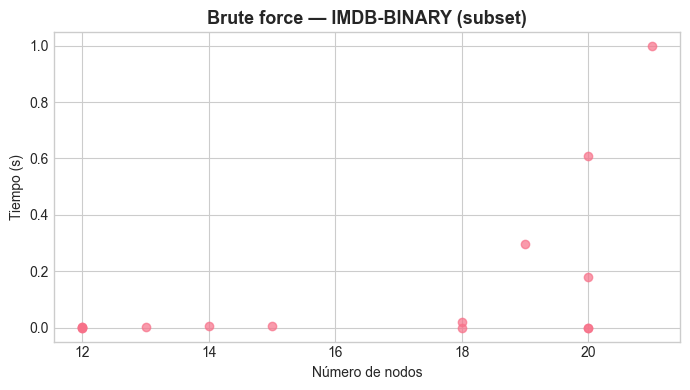

In [5]:
bench = CliqueExperiment()

bf_imdb = bench.run_bruteforce(imdb_dataset, 'IMDB-BINARY', max_graphs=20, max_nodes=25)
display(bf_imdb.head(10))

# Resumen
display(bench.summarize(bf_imdb, title="\nResumen brute force — IMDB-BINARY (subset)"))

plot_time_scatter(bf_imdb, 'Brute force — IMDB-BINARY (subset)', filename='images/bf_time_imdb.png')


## 1.5 4. Ejercicio 2 — Relajación continua: Motzkin–Straus

El teorema de Motzkin–Straus nos permite reescribir Maximum Clique como un problema continuo:

\[
\max_{x \in \Delta_n} \; f(x) = x^\top A x
\]

donde \(\Delta_n\) es el simplex (\(x_i \ge 0\) y \(\sum_i x_i = 1\)). El valor máximo está relacionado con el tamaño de la maximum clique \(\omega(G)\) según:

\[
\max_{x \in \Delta_n} x^\top A x = 1 - \frac{1}{\omega(G)}.
\]

En la práctica aparece el fenómeno de **soluciones espurias** (por ejemplo en el grafo “cherry”), por lo que suele utilizarse una versión regularizada:

\[
\hat{f}(x) = x^\top (A + \tfrac{1}{2}I) x.
\]

### 4.1 Verificación en grafos de juguete

En esta celda verifico:
- Que el valor de Motzkin–Straus coincide con \(1 - 1/k\) usando el clique máximo encontrado por brute force.
- Que en el cherry graph existen soluciones con el mismo valor (espurias) y que la regularización las penaliza.


In [6]:
def verify_motzkin_straus():
    rows = []

    # Test 1: K3 (triángulo)
    A = np.array([
        [0, 1, 1],
        [1, 0, 1],
        [1, 1, 0]
    ], dtype=float)
    clique = brute_force_max_clique(A)
    k = len(clique)
    x = np.zeros(A.shape[0])
    x[clique] = 1.0 / k

    rows.append({
        'Graph': 'K3',
        'omega (BF)': k,
        'f(x*)': motzkin_straus_objective(x, A),
        '1 - 1/omega': 1 - 1/k,
        'abs diff': abs(motzkin_straus_objective(x, A) - (1 - 1/k)),
        'f_hat(x*)': regularized_objective(x, A),
    })

    # Test 2: cuadrado + diagonal 0-2 (A2)
    A = A2.copy()
    clique = brute_force_max_clique(A)
    k = len(clique)
    x = np.zeros(A.shape[0])
    x[clique] = 1.0 / k

    rows.append({
        'Graph': 'Square+Diagonal',
        'omega (BF)': k,
        'f(x*)': motzkin_straus_objective(x, A),
        '1 - 1/omega': 1 - 1/k,
        'abs diff': abs(motzkin_straus_objective(x, A) - (1 - 1/k)),
        'f_hat(x*)': regularized_objective(x, A),
    })

    # Test 3: cherry (A3) — mostrar solución espuria
    A = A3.copy()
    # Solución "clique": {0,2}
    x_true = np.array([0.5, 0.0, 0.5])
    # Solución espuria mencionada en el enunciado: (1/4, 1/4, 1/2)
    x_spur = np.array([0.25, 0.25, 0.5])

    omega = len(brute_force_max_clique(A))

    rows.append({
        'Graph': 'Cherry (true clique)',
        'omega (BF)': omega,
        'f(x*)': motzkin_straus_objective(x_true, A),
        '1 - 1/omega': 1 - 1/omega,
        'abs diff': abs(motzkin_straus_objective(x_true, A) - (1 - 1/omega)),
        'f_hat(x*)': regularized_objective(x_true, A),
    })

    rows.append({
        'Graph': 'Cherry (spurious)',
        'omega (BF)': omega,
        'f(x*)': motzkin_straus_objective(x_spur, A),
        '1 - 1/omega': 1 - 1/omega,
        'abs diff': abs(motzkin_straus_objective(x_spur, A) - (1 - 1/omega)),
        'f_hat(x*)': regularized_objective(x_spur, A),
    })

    return pd.DataFrame(rows)

df_ms = verify_motzkin_straus()
display(df_ms)

print("\nObservación clave (Cherry): f(x) coincide en ambas soluciones, pero f_hat(x) penaliza la espuria.")


,Graph,omega (BF),f(x*),1 - 1/omega,abs diff,f_hat(x*)
0,K3,3,0.666667,0.666667,1.110223e-16,0.833333
1,Square+Diagonal,3,0.666667,0.666667,1.110223e-16,0.833333
2,Cherry (true clique),2,0.500000,0.500000,0.000000e+00,0.750000
3,Cherry (spurious),2,0.500000,0.500000,0.000000e+00,0.687500



Observación clave (Cherry): f(x) coincide en ambas soluciones, pero f_hat(x) penaliza la espuria.


## 1.6 5. Ejercicio 3 — Replicator Dynamics (RD) + Decoder

Una vez tenemos la formulación continua, necesitamos un algoritmo práctico para maximizarla bajo restricciones de simplex. RD es ideal aquí porque:

- Mantiene \(x\) siempre en el simplex (normalización).  
- En teoría, incrementa la función objetivo en cada iteración hasta converger a un punto estacionario.  
- Con la regularización \(A + 0.5I\) tiende a evitar máximos “no-clique” (espurios).

### 5.1 Visualización de convergencia en un ejemplo pequeño

Para ver “qué hace” RD, lo ejecuto en el grafo *Square+Diagonal* y muestro:
1) la curva del objetivo, 2) el vector final \(x\), y 3) el grafo coloreado por \(x\) (y resaltando la clique decodificada).


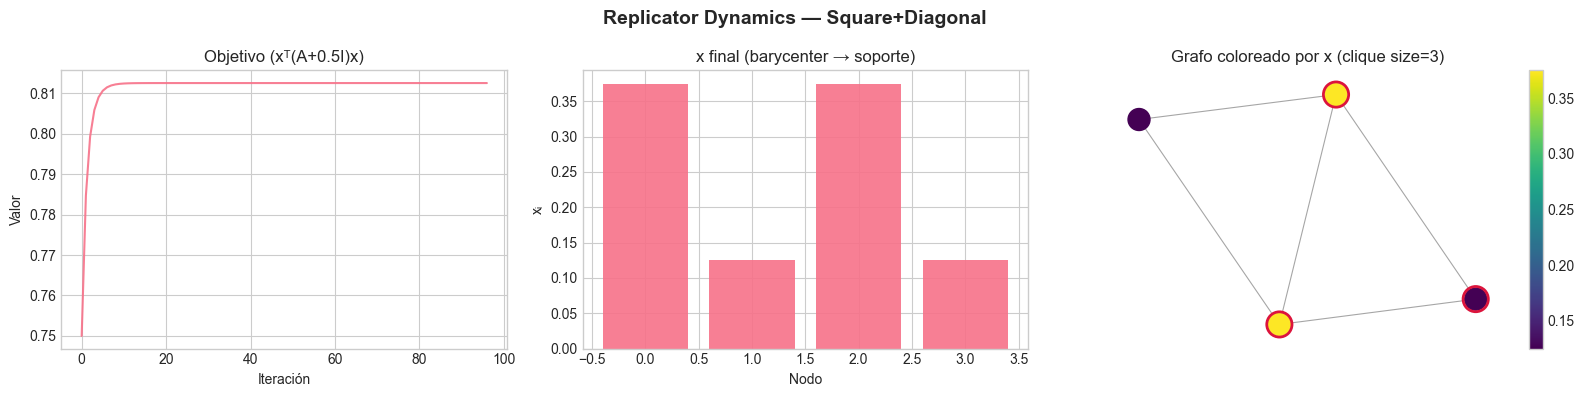

In [7]:
_ = visualize_rd(A2, graph_name='Square+Diagonal', use_regularization=True)


### 5.2 RD en IMDB-BINARY y COLLAB (50 grafos)

Aquí aplico RD (50 grafos en cada dataset) y reporto:
- Tamaño medio de clique y desviación estándar
- Tiempo medio de cómputo
- Proporción de cliques válidas (debería ser 100% porque el decoder fuerza la propiedad)

Además, donde existe brute force (subset de IMDB con <=25 nodos), comparo tamaños para estimar “exactitud”.


RD — COLLAB: 100%|██████████| 50/50 [00:00<00:00, 57.45it/s]


,Dataset,graph_idx,num_nodes,clique_size,clique,valid,time,iterations
0,IMDB-BINARY,0,20,9,"[2, 19, 6, 12, 14, 1, 17, 18, 8]",True,0.007699,406
1,IMDB-BINARY,1,32,11,"[14, 23, 13, 3, 5, 26, 29, 4, 20, 28, 21]",True,0.009394,491
2,IMDB-BINARY,2,21,10,"[2, 11, 5, 19, 0, 12, 3, 6, 7, 20]",True,0.007516,427
3,IMDB-BINARY,3,35,7,"[17, 25, 8, 2, 30, 4, 33]",True,0.006773,377
4,IMDB-BINARY,4,14,9,"[0, 11, 8, 2, 5, 6, 9, 12, 13]",True,0.006416,395
5,IMDB-BINARY,5,63,8,"[40, 47, 49, 50, 4, 13, 23, 10]",True,0.006095,373
6,IMDB-BINARY,6,12,12,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",True,0.000083,1
7,IMDB-BINARY,7,15,9,"[1, 5, 6, 14, 9, 7, 8, 0, 4]",True,0.005227,402
8,IMDB-BINARY,8,18,18,"[17, 16, 15, 14, 13, 12, 11, 10, 9, 0, 6, 5, 4...",True,0.000101,1
9,IMDB-BINARY,9,12,12,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",True,0.000076,1


,Dataset,graph_idx,num_nodes,clique_size,clique,valid,time,iterations
0,COLLAB,0,45,45,"[0, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34...",True,0.000316,1
1,COLLAB,1,52,36,"[3, 7, 49, 5, 43, 13, 2, 50, 10, 22, 36, 17, 1...",True,0.019495,1000
2,COLLAB,2,52,42,"[35, 27, 31, 49, 34, 4, 48, 22, 18, 3, 19, 41,...",True,0.018380,1000
3,COLLAB,3,32,32,"[0, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19...",True,0.000303,1
4,COLLAB,4,48,43,"[24, 40, 20, 39, 15, 22, 23, 16, 12, 11, 19, 7...",True,0.017249,1000
5,COLLAB,5,39,7,"[21, 23, 3, 34, 33, 1, 5]",True,0.005011,339
6,COLLAB,6,35,35,"[0, 19, 20, 21, 22, 23, 24, 18, 25, 27, 28, 29...",True,0.000188,1
7,COLLAB,7,81,25,"[41, 70, 75, 22, 79, 27, 24, 53, 35, 69, 30, 4...",True,0.024327,1000
8,COLLAB,8,65,25,"[53, 15, 38, 62, 21, 58, 34, 23, 59, 16, 19, 3...",True,0.018798,1000
9,COLLAB,9,49,40,"[40, 7, 32, 0, 36, 14, 4, 15, 23, 33, 25, 19, ...",True,0.015443,1000



Resumen RD — IMDB-BINARY


,Metric,Mean,Std,Min,Max
0,clique_size,10.380000,3.932543,4.000000,20.000000
1,time,0.005757,0.003052,0.000076,0.011688



Resumen RD — COLLAB


,Metric,Mean,Std,Min,Max
0,clique_size,27.300000,13.941935,5.000000,53.000000
1,time,0.014032,0.011348,0.000188,0.059523


Valid cliques (IMDB): 100.0%
Valid cliques (COLLAB): 100.0%


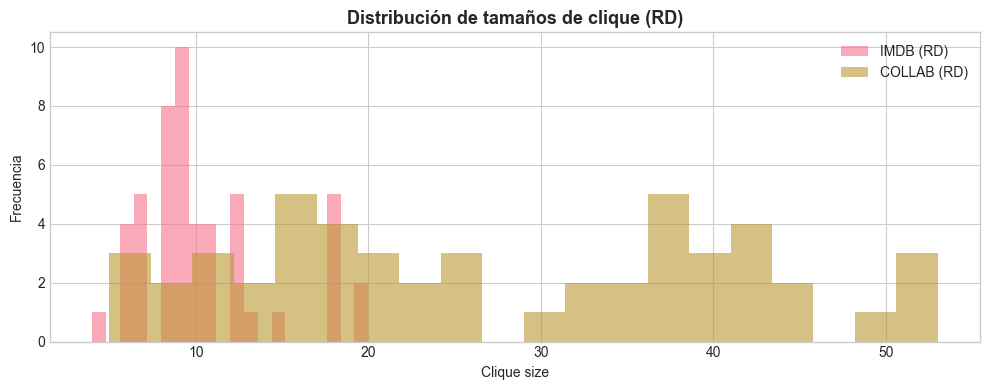

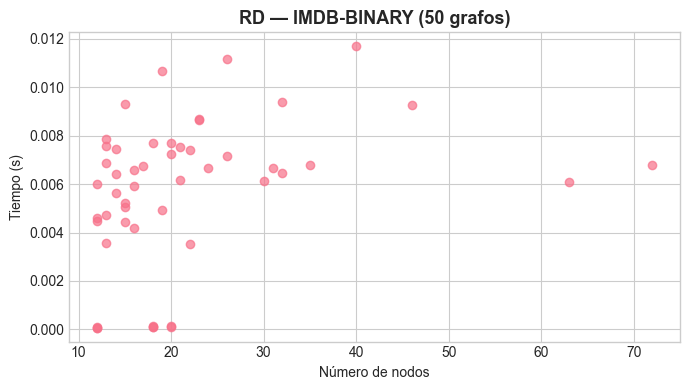

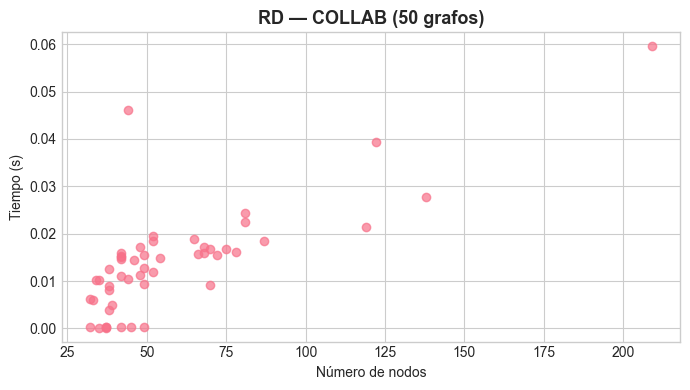

In [8]:
# RD en ambos datasets (50 grafos)
rd_imdb = bench.run_rd(imdb_dataset, 'IMDB-BINARY', num_graphs=50, max_iter=1000, tol=1e-12, use_regularization=True)
rd_collab = bench.run_rd(collab_dataset, 'COLLAB', num_graphs=50, max_iter=1000, tol=1e-12, use_regularization=True)

display(rd_imdb.head(10))
display(rd_collab.head(10))

print("\nResumen RD — IMDB-BINARY")
display(bench.summarize(rd_imdb))

print("\nResumen RD — COLLAB")
display(bench.summarize(rd_collab))

# Validación: deberían ser cliques válidas por construcción (sanity check)
print(f"Valid cliques (IMDB): {rd_imdb['valid'].mean()*100:.1f}%")
print(f"Valid cliques (COLLAB): {rd_collab['valid'].mean()*100:.1f}%")

plot_size_histograms(
    [rd_imdb, rd_collab],
    ['IMDB (RD)', 'COLLAB (RD)'],
    title='Distribución de tamaños de clique (RD)',
    filename='images/rd_size_hist.png'
)

plot_time_scatter(rd_imdb, 'RD — IMDB-BINARY (50 grafos)', filename='images/rd_time_imdb.png')
plot_time_scatter(rd_collab, 'RD — COLLAB (50 grafos)', filename='images/rd_time_collab.png')


## 1.7 6. Comparativa final (tablas + visualizaciones)

En esta sección cierro el experimento con dos comparativas:

1. **RD vs Brute Force (IMDB subset)**: solo en grafos donde brute force es factible (\(n \le 25\)).  
2. **Tabla resumen por dataset y método**: tamaño medio de clique y tiempo medio.

La métrica “Exact match rate” se define como: fracción de grafos donde RD recupera una clique del mismo tamaño que la máxima (según brute force).


,Num graphs (with BF),Exact match rate,Mean ratio (RD/BF),Median ratio (RD/BF)
0,15,1.0,1.0,1.0


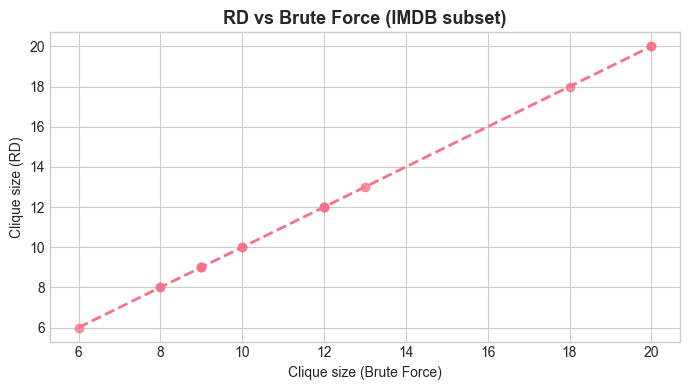

,Method,Dataset,Mean Clique Size,Std Clique Size,Mean Time (s),Std Time (s),Graphs
0,Brute Force,IMDB-BINARY (subset),11.733333,4.366539,0.141169,0.291416,15
1,Replicator Dynamics,IMDB-BINARY,10.380000,3.932543,0.005757,0.003052,50
2,Replicator Dynamics,COLLAB,27.300000,13.941935,0.014032,0.011348,50


In [9]:
# Comparación RD vs brute force (solo para grafos donde BF existe)
merged_imdb, comp_summary = bench.compare_against_ground_truth(bf_imdb, rd_imdb)
display(comp_summary)

if not merged_imdb.empty:
    plt.figure(figsize=(7,4))
    plt.scatter(merged_imdb['clique_size_bf'], merged_imdb['clique_size_rd'], alpha=0.75)
    plt.plot([merged_imdb['clique_size_bf'].min(), merged_imdb['clique_size_bf'].max()],
             [merged_imdb['clique_size_bf'].min(), merged_imdb['clique_size_bf'].max()],
             linestyle='--', linewidth=2)
    plt.title('RD vs Brute Force (IMDB subset)', fontsize=13, fontweight='bold')
    plt.xlabel('Clique size (Brute Force)')
    plt.ylabel('Clique size (RD)')
    plt.tight_layout()
    plt.savefig('images/rd_vs_bf_imdb.png', dpi=150, bbox_inches='tight')
    plt.show()

# Tabla final (sin GNN+RD porque no es parte obligatoria del enunciado en esta entrega)
summary_rows = []

def add_method_summary(method, dataset_name, df):
    if df.empty:
        return
    summary_rows.append({
        'Method': method,
        'Dataset': dataset_name,
        'Mean Clique Size': df['clique_size'].mean(),
        'Std Clique Size': df['clique_size'].std(),
        'Mean Time (s)': df['time'].mean(),
        'Std Time (s)': df['time'].std(),
        'Graphs': len(df)
    })

add_method_summary('Brute Force', 'IMDB-BINARY (subset)', bf_imdb)
add_method_summary('Replicator Dynamics', 'IMDB-BINARY', rd_imdb)
add_method_summary('Replicator Dynamics', 'COLLAB', rd_collab)

final_table = pd.DataFrame(summary_rows)
display(final_table)


## 1.8 7. Discusión y conclusiones

**1) Brute force como referencia.**  
El baseline exacto es útil para grafos pequeños: nos da una cota superior real y permite medir cuándo un método aproximado acierta exactamente. En cuanto el número de nodos crece, el coste exponencial lo vuelve impracticable.

**2) Motzkin–Straus como “puente” discreto→continuo.**  
La relajación continua es sorprendentemente informativa: el valor óptimo en el simplex está directamente ligado al tamaño de la maximum clique. La parte delicada son las **soluciones espurias**, que motivan el término de regularización \(0.5I\).

**3) RD es rápido y estable, pero no garantiza óptimo global.**  
RD tiende a encontrar cliques válidas (el decoder lo fuerza) y a producir tamaños competitivos en poco tiempo. Aun así, al ser un problema no convexo, puede converger a máximos locales dependiendo del grafo (y del punto inicial). En grafos donde disponemos de brute force, la comparación RD/BF permite cuantificar cuántas veces cae en el óptimo.

**4) Extensiones naturales.**  
Una mejora habitual es aprender una **inicialización** mejor que el barycenter (por ejemplo con una GNN), y luego refinar con RD. Esto aparece como extensión en el enunciado, pero no es requisito obligatorio en esta entrega.
